In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import numpy as np
import tensorflow as tf
import os.path as osp
import matplotlib.pylab as plt
from collections import defaultdict
import time

In [3]:
from general_tools.notebook.tf import reset_tf_graph
from geo_tool import Point_Cloud, Mesh
from geo_tool.solids.plotting import plot_mesh_via_matplotlib as plot_mesh

In [4]:
import helper

from tf_lab.diff_maps.in_out import raw_data, produce_net_data,\
prep_splits_labels_for_task, produce_diff_maps, classes_of_tasks

from tf_lab.diff_maps.basic_nets import pc_net, diff_mlp_net, diff_conv_net, pc_versions
from tf_lab.diff_maps.basic_nets import Basic_Net

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
def average_l2_distance(gt_vecs, pred_vecs):
    return np.mean(np.sqrt(np.sum(np.square((gt_vecs - pred_vecs)), axis=1)))

def average_mse(gt_vecs, pred_vecs):
    return np.mean(np.sum(np.square((gt_vecs - pred_vecs))))

def score_net(task, stats):
    train_s = np.array(stats['train'])
    test_s = np.array(stats['test'])
    val_s = np.array(stats['val'])

    if task == 'regression':
        seek = np.min(val_s)
    else:
        seek = np.max(val_s)

    val_best_all = np.where(val_s == seek)[0]
    val_maximizer = val_best_all[0]
    test_best = test_s[val_maximizer]
    train_best = train_s[val_maximizer]
    gen_error = test_best - train_best   
    return len(val_best_all), val_maximizer, gen_error[0], test_best[0]

In [7]:
total_shapes = helper.total_shapes
n_pose_classes = helper.n_pose_classes
seeds = [42, 100, 666, 1821, 2004]

top_mesh_dir = '/orions4-zfs/projects/optas/DATA/Meshes/SCAPE_8_poses/'
gt_param_f = osp.join(top_mesh_dir, 'gt_shape_params.mat')
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses'

In [8]:
n_cons = 40
use_pc = False
knn = 0
arch = 'mlp'
sub_member_per_class = 50
n_shapes = sub_member_per_class * n_pose_classes
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)
n_pc_points = 1024
# task = 'regression'
task = 'pose_clf'
mean_norm_diffs = True
synced_bases_file = osp.join(top_data_dir, '50_extract_%d_knn_50_fmapd.mat' % (knn,) )

In [9]:
if use_pc:
    learning_rate = 0.005
    batch_size = 50
    pc_version = 'v2'
else:
    learning_rate = 0.007
    batch_size = 50

In [10]:
gt_latent_params, in_pcs, pose_labels = \
raw_data(top_mesh_dir, gt_param_f, sub_member_per_class, n_pc_points)
n_classes = classes_of_tasks(task)

In [11]:
verbose = True
train_epochs = 500
stats_over_reps = defaultdict(list)

seed = seeds[0]
np.random.seed(seed)

# Prepare splits
diff_maps = produce_diff_maps(synced_bases_file, n_cons, n_shapes)

splits, labels = \
prep_splits_labels_for_task(task, gt_latent_params, pose_labels, train_per, test_per, seed)
net_data = produce_net_data(in_pcs, splits, labels, diff_maps, use_pc, mean_norm_diffs)

# Prepare graph
reset_tf_graph()
tf.set_random_seed(seed)        

if use_pc:
    n_filters, n_neurons = pc_versions(pc_version)
    net_out, feed_pl, label_pl = pc_net(n_pc_points, task, n_filters, n_neurons, verbose)
else:
    if arch=='conv':
        net_out, feed_pl, label_pl = diff_conv_net(n_cons, task, True)
    else:
        net_out, feed_pl, label_pl = diff_mlp_net(n_cons, task, True)

net = Basic_Net(net_out, feed_pl, label_pl)
net.define_loss(task)

net.define_opt(learning_rate)
# net.define_opt(0.0007)
net.start_session()

#PARAMS  34025


In [13]:
# Train
start_time = time.time()
stats = net.train(train_epochs, batch_size, net_data, task, verbose=False)
n_opt, val_maximizer, gen_error, test_best = score_net(task, stats)
end_time = time.time()
print n_opt, val_maximizer, gen_error, test_best
# print end_time-start_time

100 0 0.0 1.0


In [32]:
test_params = net_data['test'].labels
test_feed = {net.feed_pl:net_data['test'].feed}
test_pred = net.sess.run(net.net_out, feed_dict=test_feed)

In [33]:
n_test = net_data['test'].n_examples
mu_train = net_data['train'].labels
mu_train = np.repeat(np.mean(mu_train, axis=0), n_test).reshape(12, n_test).T

print average_l2_distance(test_params, mu_train)
print average_l2_distance(test_params, test_pred)

print np.sum(abs(mu_train-test_params)) / test_params.size
print np.sum(abs(test_pred-test_params)) / test_params.size

print average_mse(test_params, mu_train) / test_params.size

0.080691504173


In [ ]:
# PLOT net stats.
plt.plot(train_res['train'])
plt.plot(train_res['test'])
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

if use_pc:
    title_tag = 'Raw input'
else:
    title_tag = 'Diff-map input (%s)' % (arch,)

plt.title('%s Net-stats for body-variation.'% (title_tag, ))
# plt.text(100, 0.3, 'best by val:%.4f' % (val_best,), fontsize=12);

In [58]:
from general_tools.clustering.plt import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
s = 'test'
l = in_data[s].labels

feed_dict = {feed_pl:in_data[s].feed, labels_pl:l}
p = sess.run([prediction], feed_dict=feed_dict)[0]

conf_m = confusion_matrix(l, p)

Confusion matrix, without normalization
[[2 0 0 0 1 0 0 1 1 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 1 0 0 0 0 0 0 0 0]
 [1 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 1 0 5 0 0 0 0 0 0]
 [0 0 1 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 1 0 0 5 0 0 0 0]
 [0 0 0 0 1 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0]
 [1 0 0 0 0 0 0 0 0 0 3 1]
 [0 0 0 0 0 0 0 0 0 1 0 3]]


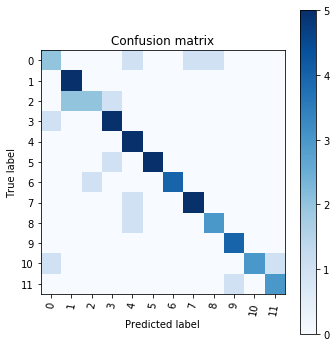

In [62]:
import inspect
inspect.getargspec(plot_confusion_matrix)
plot_confusion_matrix(conf_m, np.unique(in_labels))

In [207]:
grid_scaler = np.arange(np.prod(diff_dims)).reshape(diff_dims)
loc_scaled_diffs = []
for d in in_diffs:
    loc_scaled_diffs.append(d + grid_scaler)

In [164]:
def add_location_info_on_diffs(in_diffs, scaler=1.0):
    diff_dims = in_diffs.shape[1:]
    row_pos = np.repeat(np.arange(diff_dims[0]), diff_dims[1]).reshape(diff_dims)
    col_pos = np.repeat(np.arange(diff_dims[1]), diff_dims[0]).reshape(diff_dims[1], diff_dims[0]).T
    row_pos = row_pos.astype(np.float32)
    col_pos = col_pos.astype(np.float32)
    row_pos *= scaler
    col_pos *= scaler

    diffs_with_pos = np.zeros(shape=in_diffs.shape + (3,))
    for i, d in enumerate(in_diffs):
        diffs_with_pos[i, :, :, 0] = d
        diffs_with_pos[i, :, :, 1] = row_pos
        diffs_with_pos[i, :, :, 2] = col_pos
    return diffs_with_pos


In [ ]:
import hdf5storage
lsd_exempler_f = osp.join(top_data_dir, 'lsd_exemplar.mat')
def load_lsd_exemplars(in_file, conf_type='lsd_20'):
    lsd_exemplars = hdf5storage.loadmat(lsd_exempler_f)
    lsd_exemplars = lsd_exemplars[conf_type]
    n_shapes = len(lsd_exemplars)
    map_shape = lsd_exemplars[0][0].shape
    res = np.zeros(shape=(n_shapes, ) + map_shape )
    for i in xrange(n_shapes):
        res[i] = lsd_exemplars[i][0]
    return res
lsd_type = 'lsd_20'
lsd_exemplars = load_lsd_exemplars(lsd_exempler_f, conf_type=lsd_type)
n_cons = lsd_exemplars.shape[-1]